In [90]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
from transformers import Swinv2Model
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
from torchvision.transforms import functional as F
import os
import collections
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom

DEVICE = torch.device('cuda')

In [ ]:
df_metadata = pd.read_csv("./Original CSVs/metadata.csv")
df_calc_train = pd.read_csv("./Original CSVs/calc_case_description_train_set.csv")
df_calc_test = pd.read_csv("./Original CSVs/calc_case_description_test_set.csv")
df_mass_train = pd.read_csv("./Original CSVs/mass_case_description_train_set.csv")
df_mass_test = pd.read_csv("./Original CSVs/mass_case_description_test_set.csv")

df_fullimages_metadata = pd.DataFrame()
df_fullimages_metadata = df_metadata.loc[df_metadata["Series Description"] == "full mammogram images"]

df_croppedimages_metadata = pd.DataFrame()
df_croppedimages_metadata = df_metadata.loc[df_metadata["Series Description"] == "cropped images"]

df_roiimages_metadata = pd.DataFrame()
df_roiimages_metadata = df_metadata.loc[df_metadata["Series Description"] == "ROI mask images"]

In [ ]:
def get_dicom_height(dicom_path):
    dicom_file = pydicom.dcmread(dicom_path)
    return dicom_file.Rows

def get_dicom_width(dicom_path):
    dicom_file = pydicom.dcmread(dicom_path)
    return dicom_file.Columns

def process_dataframe(df_input, df_fullimages_metadata, df_roiimages_metadata):

    # Copying the relevant columns from the original dataframe
    df_output = df_input[["patient_id", "abnormality type", "pathology"]].copy()
    df_output["pathology"] = df_output["pathology"].replace("BENIGN_WITHOUT_CALLBACK", "BENIGN")

    # Splitting out the first part of the path to get the ID
    df_output["full image id"] = df_input["image file path"].apply(lambda x: x.split('/')[0])
    df_output["roi mask id"] = df_input["ROI mask file path"].apply(lambda x: x.split('/')[0])

    # Check to make sure that the ID is present in the metadata file, if not they are dropped as the image does not exist in the dataset
    df_output["full image id isin"] = df_output["full image id"].isin(df_fullimages_metadata["Subject ID"])
    df_output["roi mask id isin"] = df_output["roi mask id"].isin(df_roiimages_metadata["Subject ID"])
    df_output = df_output.drop(df_output[df_output["full image id isin"] == False].index)
    df_output = df_output.drop(df_output[df_output["roi mask id isin"] == False].index)

    # Getting the actual full image path
    df_output["full image path"] = df_output.apply(
        lambda row: df_fullimages_metadata.loc[df_fullimages_metadata["Subject ID"] == row["full image id"], "File Location"].item(),
        axis=1
    )

    # Checking to make sure the full image file exists if not the row is dropped
    df_output["full image path"] = df_output["full image path"].apply(lambda x: x.replace("\\", "/")+"/1-1.dcm")
    df_output["full image path exists"] = df_output["full image path"].apply(lambda x: os.path.exists(x))
    df_output = df_output.drop(df_output[df_output["full image path exists"] == False].index)

    # # Recording the full image dimensions
    # df_output["full image height"] = df_output["full image path"].apply(get_dicom_height)
    # df_output["full image width"] = df_output["full image path"].apply(get_dicom_width)

    # Creating the full image png path
    df_output["full image png"] = df_output["full image id"].apply(lambda x: "./PNGs/" + x + ".png")

    # Getting the actual roi image path
    df_output["roi image path"] = df_output.apply(
        lambda row: df_roiimages_metadata.loc[df_roiimages_metadata["Subject ID"] == row["roi mask id"], "File Location"].item(),
        axis=1
    )

    # Checking to make sure the roi image file exists if not the row is dropped
    df_output["roi image path"] = df_output["roi image path"].apply(lambda x: x.replace("\\", "/")+"/1-2.dcm")
    df_output["roi image path exists"] = df_output["roi image path"].apply(lambda x: os.path.exists(x))
    df_output = df_output.drop(df_output[df_output["roi image path exists"] == False].index)

    # # Recording the roi image dimensions
    # df_output["roi image height"] = df_output["roi image path"].apply(get_dicom_height)
    # df_output["roi image width"] = df_output["roi image path"].apply(get_dicom_width)

    # Creating the full image png path
    df_output["roi image png"] = df_output["roi mask id"].apply(lambda x: "./PNGs/" + x + ".png")

    return df_output

In [ ]:
# Process all dataframes and save into processed csv files to save on compute time if a rerun is required

# df_calc_train_processed = process_dataframe(df_calc_train, df_fullimages_metadata, df_roiimages_metadata)
# df_calc_test_processed = process_dataframe(df_calc_test, df_fullimages_metadata, df_roiimages_metadata)
# df_mass_train_processed = process_dataframe(df_mass_train, df_fullimages_metadata, df_roiimages_metadata)
# df_mass_test_processed = process_dataframe(df_mass_test, df_fullimages_metadata, df_roiimages_metadata)

# df_calc_train_processed.to_csv("./Processed CSVs/df_calc_train_processed.csv")
# df_calc_test_processed.to_csv("./Processed CSVs/df_calc_test_processed.csv")
# df_mass_train_processed.to_csv("./Processed CSVs/df_mass_train_processed.csv")
# df_mass_test_processed.to_csv("./Processed CSVs/df_mass_test_processed.csv")

df_calc_train_processed = pd.read_csv("./Processed CSVs/df_calc_train_processed.csv")
df_calc_test_processed = pd.read_csv("./Processed CSVs/df_calc_test_processed.csv")
df_mass_train_processed = pd.read_csv("./Processed CSVs/df_mass_train_processed.csv")
df_mass_test_processed = pd.read_csv("./Processed CSVs/df_mass_test_processed.csv")

In [30]:
# Helper function to convert the dicom images to png while maintaining aspect ratio

def dicom_to_padded_png(dicom_path, output_path, dtype, size=(1024, 1024)):
    ds = pydicom.dcmread(dicom_path)
    pixel_array = ds.pixel_array

    # Normalize based on min/max values
    pixel_array = (pixel_array - np.min(pixel_array)) / (np.max(pixel_array) - np.min(pixel_array))
    pixel_array = (pixel_array * 255).astype(dtype)

    # Create a PIL Image from the pixel array
    img = Image.fromarray(pixel_array)

    # Get the new size while maintaining aspect ratio
    original_width, original_height = img.size
    target_width, target_height = size

    # Scale the image
    scale = min(target_width / original_width, target_height / original_height)
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)

    # Resize the image using the Lanczos filter for maximum image quality
    resized_img = img.resize((new_width, new_height), Image.LANCZOS)

    # Create a new blank square image with black padding
    padded_img = Image.new("L", size)
    left = (target_width - new_width) // 2
    top = (target_height - new_height) // 2
    padded_img.paste(resized_img, (left, top))

    # Save the padded image as PNG
    padded_img.save(output_path)

def dicom_to_png(dicom_path, png_path, dtype):
    dicom_file = pydicom.dcmread(dicom_path)
    pixel_array = dicom_file.pixel_array
    pixel_array = pixel_array.astype(dtype)
    img = Image.fromarray(pixel_array)
    img.save(png_path)

In [ ]:
# Convert calc train images to png

for index, row in df_calc_train_processed.iterrows():
    dicom_to_padded_png(row["full image path"], row["full image png"], np.uint16)
    dicom_to_padded_png(row["roi image path"], row["roi image png"], np.uint8)

print("Complete df_calc_train_processed")

In [45]:
# Convert calc test images to png

for index, row in df_calc_test_processed.iterrows():
    dicom_to_padded_png(row["full image path"], row["full image png"], np.uint16)
    dicom_to_padded_png(row["roi image path"], row["roi image png"], np.uint8)

print("Complete df_calc_test_processed")

Complete df_calc_test_processed


In [46]:
# Convert mass train images to png

for index, row in df_mass_train_processed.iterrows():
    dicom_to_padded_png(row["full image path"], row["full image png"], np.uint16)
    dicom_to_padded_png(row["roi image path"], row["roi image png"], np.uint8)

print("Complete df_mass_train_processed")

Complete df_mass_train_processed


In [47]:
# Convert mass test images to png

for index, row in df_mass_test_processed.iterrows():
    dicom_to_padded_png(row["full image path"], row["full image png"], np.uint16)
    dicom_to_padded_png(row["roi image path"], row["roi image png"], np.uint8)

print("Complete df_mass_test_processed")

Complete df_mass_test_processed


In [31]:
def get_bounding_boxes(mask_path):
 
    # Open the image and convert it to grayscale
    with Image.open(mask_path).convert("L") as img:
        # Get the bounding box of all non-zero regions
        bbox = img.getbbox()
        if bbox:
            # Pillow's getbbox returns (left, upper, right, lower)
            x_min, y_min, x_max, y_max = bbox
            return (x_min, y_min, x_max, y_max)
        else:
            # The image is completely black
            print("There is an empty image")
            return None


In [32]:
df_calc_train_processed["roi bb coordinates"] = df_calc_train_processed["roi image png"].apply(get_bounding_boxes)
df_calc_test_processed["roi bb coordinates"] = df_calc_test_processed["roi image png"].apply(get_bounding_boxes)
df_mass_train_processed["roi bb coordinates"] = df_mass_train_processed["roi image png"].apply(get_bounding_boxes)
df_mass_test_processed["roi bb coordinates"] = df_mass_test_processed["roi image png"].apply(get_bounding_boxes)

# df_calc_train_processed.to_csv("./Processed CSVs/df_calc_train_processed.csv")
# df_calc_test_processed.to_csv("./Processed CSVs/df_calc_test_processed.csv")
# df_mass_train_processed.to_csv("./Processed CSVs/df_mass_train_processed.csv")
# df_mass_test_processed.to_csv("./Processed CSVs/df_mass_test_processed.csv")

In [33]:
all_training = pd.concat([df_calc_train_processed, df_mass_train_processed], ignore_index=True)
all_test = pd.concat([df_calc_test_processed, df_mass_test_processed], ignore_index=True)

In [ ]:
class CBISDDSMDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        # Define the class mapping for classification
        self.class_map = {
            'BENIGN': 0,
            'MALIGNANT': 1,
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the row for the current index
        row = self.dataframe.iloc[idx]
        image_path = row['roi image png']
        
        # Load the image and convert to RGB
        img = Image.open(image_path).convert("RGB")
        
        # The bounding box coordinates are already a tuple.
        boxes = [list(row['roi bb coordinates'])]
        
        # Calculate a square crop around the bounding box
        x_min, y_min, x_max, y_max = boxes[0]
        center_x = (x_min + x_max) / 2
        center_y = (y_min + y_max) / 2
        
        # Ensure the crop is a square that fully contains the bounding box
        box_width = x_max - x_min
        box_height = y_max - y_min
        max_dim = max(box_width, box_height) * 1.2

        # Define crop coordinates
        crop_x_min = int(center_x - max_dim / 2)
        crop_y_min = int(center_y - max_dim / 2)
        crop_x_max = int(center_x + max_dim / 2)
        crop_y_max = int(center_y + max_dim / 2)

        # Clamp crop coordinates to image boundaries
        original_width, original_height = img.size
        crop_x_min = max(0, crop_x_min)
        crop_y_min = max(0, crop_y_min)
        crop_x_max = min(original_width, crop_x_max)
        crop_y_max = min(original_height, crop_y_max)

        # Perform the crop
        cropped_img = F.crop(img, crop_y_min, crop_x_min, crop_y_max - crop_y_min, crop_x_max - crop_x_min)

        # Resize the cropped image to 384x384
        resized_img = F.resize(cropped_img, (384, 384))

        # Calculate scaling factors for bounding box coordinates
        cropped_width, cropped_height = cropped_img.size
        new_width, new_height = resized_img.size
        width_scale = new_width / cropped_width
        height_scale = new_height / cropped_height

        # Scale bounding box coordinates to match the new image size and crop
        scaled_boxes = []
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            scaled_x_min = (x_min - crop_x_min) * width_scale
            scaled_y_min = (y_min - crop_y_min) * height_scale
            scaled_x_max = (x_max - crop_x_min) * width_scale
            scaled_y_max = (y_max - crop_y_min) * height_scale
            scaled_boxes.append([scaled_x_min, scaled_y_min, scaled_x_max, scaled_y_max])

        boxes = torch.as_tensor(scaled_boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        img_tensor = F.to_tensor(resized_img)

        # Get the classification label for the Swin UNETR
        class_label = self.class_map[row['pathology']]
        class_label_tensor = torch.as_tensor([class_label], dtype=torch.long)

        return img_tensor, target, class_label_tensor

# Collate function for the DataLoader
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    class_labels = [item[2] for item in batch]
    return images, targets, class_labels

In [ ]:
def get_faster_rcnn_model(num_classes):
    backbone_model = Swinv2Model.from_pretrained("microsoft/swinv2-large-patch4-window12to24-192to384-22kto1k-ft", add_pooling_layer=False)
    in_channels_list = [192, 384, 768, 1536]
    out_channels = 256

    class SwinFPNBackbone(nn.Module):
        def __init__(self, swin_model, in_channels_list, out_channels):
            super().__init__()
            self.swin_model = swin_model
            self.fpn = FeaturePyramidNetwork(in_channels_list, out_channels)
            self.out_channels = out_channels
        
        def forward(self, x):
            outputs = self.swin_model(pixel_values=x, output_hidden_states=True)
            feature_maps = outputs.reshaped_hidden_states
            swin_features = collections.OrderedDict()
            swin_features['0'] = feature_maps[0]
            swin_features['1'] = feature_maps[1]
            swin_features['2'] = feature_maps[2]
            swin_features['3'] = feature_maps[3]
            fpn_features = self.fpn(swin_features)
            return fpn_features

    backbone = SwinFPNBackbone(backbone_model, in_channels_list, out_channels)
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 4
    )
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'],
                                                    output_size=7,
                                                    sampling_ratio=2)
    model = FasterRCNN(backbone,
                       num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)
    return model

class SwinUNETRMultiTask(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = Swinv2Model.from_pretrained("microsoft/swinv2-large-patch4-window12to24-192to384-22kto1k-ft", add_pooling_layer=False)
        
        # Segmentation Decoder for upsampling with Skip Connections
        self.upsample1 = nn.ConvTranspose2d(1536, 768, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(1536, 768, kernel_size=3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(768, 384, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(768, 384, kernel_size=3, padding=1)
        self.upsample3 = nn.ConvTranspose2d(384, 192, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(384, 192, kernel_size=3, padding=1)
        self.upsample4 = nn.ConvTranspose2d(192, 96, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(192, 96, kernel_size=3, padding=1)
        self.seg_head = nn.Conv2d(96, 1, kernel_size=1)

        # Classification Head
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.cls_head = nn.Sequential(
            nn.Linear(1536, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        outputs = self.encoder(pixel_values=x, output_hidden_states=True)
        # Extract features from the different stages of the Swin Transformer
        features_stage1 = outputs.reshaped_hidden_states[0]
        features_stage2 = outputs.reshaped_hidden_states[1]
        features_stage3 = outputs.reshaped_hidden_states[2]
        features_stage4 = outputs.reshaped_hidden_states[3]

        # Segmentation pathway with skip connections
        seg_out = self.upsample1(features_stage4)
        seg_out = torch.cat([seg_out, features_stage3], dim=1)
        seg_out = self.conv1(seg_out)
        
        seg_out = self.upsample2(seg_out)
        seg_out = torch.cat([seg_out, features_stage2], dim=1)
        seg_out = self.conv2(seg_out)
        
        seg_out = self.upsample3(seg_out)
        seg_out = torch.cat([seg_out, features_stage1], dim=1)
        seg_out = self.conv3(seg_out)
        
        seg_out = self.upsample4(seg_out)
        seg_out = self.conv4(seg_out)
        seg_output = self.seg_head(seg_out)

        # Classification pathway
        cls_features = self.avg_pool(features_stage4)
        cls_output = self.cls_head(cls_features.view(cls_features.size(0), -1))
        
        return seg_output, cls_output

In [88]:
def calculate_iou(box1, box2):
    """Calculates the Intersection over Union (IoU) of two bounding boxes."""
    x1, y1, x2, y2 = box1
    x1_gt, y1_gt, x2_gt, y2_gt = box2
    inter_x1 = max(x1, x1_gt)
    inter_y1 = max(y1, y1_gt)
    inter_x2 = min(x2, x2_gt)
    inter_y2 = min(y2, y2_gt)
    inter_width = max(0, inter_x2 - inter_x1)
    inter_height = max(0, inter_y2 - inter_y1)
    intersection = inter_width * inter_height
    area_pred = (x2 - x1) * (y2 - y1)
    area_gt = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    union = area_pred + area_gt - intersection
    if union == 0:
        return 0.0
    return intersection / union

def calculate_dice(box1, box2):
    """Calculates the Dice Similarity Coefficient of two bounding boxes."""
    iou = calculate_iou(box1, box2)
    return (2 * iou) / (1 + iou)

def evaluate_faster_rcnn(model, data_loader):
    model.eval()
    iou_scores = []
    dice_scores = []
    with torch.no_grad():
        for images, targets, _ in data_loader:
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            detections = model(images)
            for i, (detection, target) in enumerate(zip(detections, targets)):
                gt_box = target['boxes'][0].cpu().numpy()
                if len(detection['boxes']) > 0:
                    pred_box = detection['boxes'][0].cpu().numpy()
                    iou = calculate_iou(pred_box, gt_box)
                    dice = calculate_dice(pred_box, gt_box)
                    iou_scores.append(iou)
                    dice_scores.append(dice)
                else:
                    iou_scores.append(0)
                    dice_scores.append(0)
    if len(iou_scores) == 0:
      return 0.0, 0.0
    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)
    return avg_iou, avg_dice

def evaluate_swin_unetr(model, data_loader, class_map):
    model.eval()
    pixel_iou_scores = []
    pixel_dice_scores = []
    all_true_labels = []
    all_predicted_labels = []
    with torch.no_grad():
        for images, targets, class_labels in data_loader:
            images = list(image.to(DEVICE) for image in images)
            for i, (image, target) in enumerate(zip(images, targets)):
                gt_box = target['boxes'][0].cpu().int().tolist()
                x1, y1, x2, y2 = gt_box
                cropped_roi = F.crop(image, y1, x1, y2 - y1, x2 - x1)
                resized_roi = F.resize(cropped_roi, (384, 384)).unsqueeze(0)
                dummy_gt_mask = torch.zeros_like(resized_roi)
                dummy_gt_mask[:, 50:334, 50:334] = 1 
                seg_output, cls_logits = model(resized_roi)
                predicted_mask = (torch.sigmoid(seg_output) > 0.5).int()
                intersection = (predicted_mask * dummy_gt_mask).sum()
                union = (predicted_mask + dummy_gt_mask).sum() - intersection
                pixel_iou = intersection / union if union > 0 else 0.0
                pixel_dice = (2. * intersection) / (predicted_mask.sum() + dummy_gt_mask.sum())
                pixel_iou_scores.append(pixel_iou.item())
                pixel_dice_scores.append(pixel_dice.item())
                predicted_class = torch.argmax(cls_logits, dim=1).item()
                true_class = class_labels[i].item()
                all_true_labels.append(true_class)
                all_predicted_labels.append(predicted_class)
    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='macro', zero_division=0)
    return accuracy, precision, recall, f1_score, sum(pixel_iou_scores)/len(pixel_iou_scores), sum(pixel_dice_scores)/len(pixel_dice_scores)

def run_experiment(lr, num_epochs, train_loader, test_loader, num_detection_classes, num_classification_classes, class_map):
    """Runs a complete experiment with a given set of hyperparameters and returns the results."""
    faster_rcnn_model = get_faster_rcnn_model(num_classes=num_detection_classes).to(DEVICE)
    faster_rcnn_optimizer = torch.optim.AdamW(faster_rcnn_model.parameters(), lr=lr)
    # train_model(faster_rcnn_model, train_loader, faster_rcnn_optimizer, num_epochs)
    iou, dice = evaluate_faster_rcnn(faster_rcnn_model, test_loader)
    swin_unetr_model = SwinUNETRMultiTask(num_classes=num_classification_classes).to(DEVICE)
    accuracy, precision, recall, f1_score, pixel_iou, pixel_dice = evaluate_swin_unetr(swin_unetr_model, test_loader, class_map)
    return {
        'learning_rate': lr,
        'Faster R-CNN IoU': iou,
        'Faster R-CNN Dice': dice,
        'Swin UNETR Accuracy': accuracy,
        'Swin UNETR Precision': precision,
        'Swin UNETR Recall': recall,
        'Swin UNETR F1-Score': f1_score,
        'Swin UNETR Pixel IoU': pixel_iou,
        'Swin UNETR Pixel Dice': pixel_dice,
    }

def plot_results(results_df):
    """Generates and displays plots for comparing experiment results."""
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    results_df.plot(x='learning_rate', y=['Faster R-CNN IoU', 'Faster R-CNN Dice'], kind='bar', ax=axes[0], rot=0)
    axes[0].set_title('Stage 1: Faster R-CNN Performance')
    axes[0].set_ylabel('Score')
    axes[0].set_xlabel('Learning Rate')
    axes[0].legend(title='Metric')
    results_df.plot(x='learning_rate', y=['Swin UNETR Accuracy', 'Swin UNETR F1-Score'], kind='bar', ax=axes[1], rot=0)
    axes[1].set_title('Stage 2: Swin UNETR Performance')
    axes[1].set_ylabel('Score')
    axes[1].set_xlabel('Learning Rate')
    axes[1].legend(title='Metric')
    plt.tight_layout()
    plt.show()

def train_model(model, data_loader, optimizer, num_epochs):
    model.to(DEVICE)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for i, (images, targets, _) in enumerate(data_loader):
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}] finished. Average Loss: {total_loss / len(data_loader):.4f}')
    print("Faster R-CNN training complete.")

In [89]:
train_dataset = CBISDDSMDataset(all_training)
test_dataset = CBISDDSMDataset(all_test)
train_data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# --- Step 2: Hyperparameter Tuning Setup ---
NUM_DETECTION_CLASSES = 2 
NUM_CLASSIFICATION_CLASSES = 2
NUM_EPOCHS = 1
hyperparameters = [
    {'lr': 1e-4},
    {'lr': 1e-5},
    {'lr': 1e-6},
]
all_results = []

# --- Step 3: Run Experiments ---
print("Starting Hyperparameter Tuning...")
for params in hyperparameters:
    print(f"\n--- Running Experiment with LR: {params['lr']} ---")
    results = run_experiment(
        lr=params['lr'],
        num_epochs=NUM_EPOCHS,
        train_loader=train_data_loader,
        test_loader=test_data_loader,
        num_detection_classes=NUM_DETECTION_CLASSES,
        num_classification_classes=NUM_CLASSIFICATION_CLASSES,
        class_map=train_dataset.class_map
    )
    all_results.append(results)

Starting Hyperparameter Tuning...

--- Running Experiment with LR: 0.0001 ---


RuntimeError: Given groups=1, weight of size [96, 192, 3, 3], expected input[1, 96, 192, 192] to have 192 channels, but got 96 channels instead



--- Experiment Results Summary ---
   learning_rate  Faster R-CNN IoU  Faster R-CNN Dice  Swin UNETR Accuracy  \
0       0.000100          0.013880           0.024478             0.584660   
1       0.000010          0.212090           0.308269             0.396527   
2       0.000001          0.001027           0.001853             0.604920   

   Swin UNETR Precision  Swin UNETR Recall  Swin UNETR F1-Score  \
0              0.393746           0.486916             0.381545   
1              0.198263           0.500000             0.283938   
2              0.802174           0.501825             0.380330   

   Swin UNETR Pixel IoU  Swin UNETR Pixel Dice  
0                   0.0                    0.0  
1                   0.0                    0.0  
2                   0.0                    0.0  


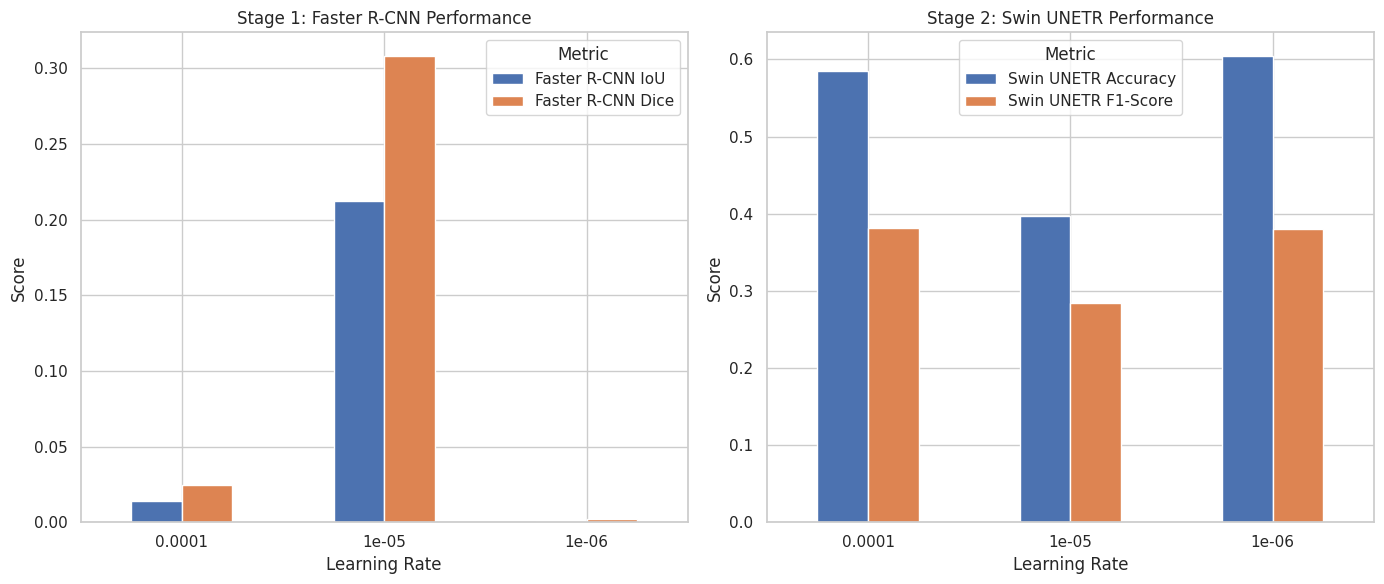

In [48]:
# --- Step 4: Compare Results ---
results_df = pd.DataFrame(all_results)
print("\n\n--- Experiment Results Summary ---")
print(results_df)
plot_results(results_df)